# 03 - Statistical Analysis & Hypothesis Testing

Rigorous statistical analysis of Stadium vs Federation/Club projects.

**Research Hypotheses:**
- **H1**: Stadium projects exhibit significantly lower contributor entropy than Federation projects
- **H2**: Stadium projects show higher Gini coefficients (contribution inequality)
- **H3**: Stadium entropy correlates with VSM S2 (coordination) metrics
- **H4**: Stadium projects have faster PR merge times (centralized decision-making)
- **H5**: Stadium projects have fewer governance files
- **H6**: Entropy predicts project classification with >80% accuracy

## Setup

In [14]:
import json
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import mannwhitneyu, ttest_ind, pearsonr, spearmanr
import statsmodels.api as sm
from statsmodels.stats.power import TTestIndPower
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

# Add src to path
sys.path.insert(0, '../src')
from analysis.entropy_calculation import EntropyCalculator

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]

print("✅ Setup complete!")

✅ Setup complete!


## 1. Load and Prepare Data

In [15]:
# Load all collected project data
data_dir = Path("../data/raw")
data_files = list(data_dir.glob("*_data.json"))

print(f"Found {len(data_files)} data file(s)")

projects = []
entropy_calc = EntropyCalculator()

for file_path in data_files:
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    repo = data['repository']
    contributors = data.get('contributors', [])
    maintainers = data.get('maintainers', {}).get('statistics', {})
    pr_stats = data.get('pull_requests', {}).get('statistics', {})
    issue_stats = data.get('issues', {}).get('statistics', {})
    gov_files = data.get('governance_files', {})
    
    # Calculate entropy metrics
    if contributors:
        entropy, normalized_entropy = entropy_calc.contributor_entropy(contributors)
        contributions = [c.get('contributions', 0) for c in contributors]
        gini = entropy_calc.gini_coefficient(contributions)
        
        total_contrib = sum(contributions)
        top_pct = contributions[0] / total_contrib * 100 if total_contrib > 0 else 0
        top_2_pct = sum(contributions[:2]) / total_contrib * 100 if total_contrib > 0 else 0
    else:
        entropy, normalized_entropy, gini = 0, 0, 0
        top_pct, top_2_pct = 0, 0
    
    # Count governance files
    gov_count = sum(1 for v in gov_files.values() if v)
    
    projects.append({
        'repository': repo.get('full_name', 'Unknown'),
        'language': repo.get('language', 'Unknown'),
        'stars': repo.get('stargazers_count', 0),
        'forks': repo.get('forks_count', 0),
        'contributors': len(contributors),
        'active_maintainers': maintainers.get('active_maintainers_6mo', 0),
        'commits': len(data.get('recent_commits', [])),
        
        # Entropy metrics
        'entropy': entropy,
        'normalized_entropy': normalized_entropy,
        'gini': gini,
        'top_contributor_pct': top_pct,
        'top_2_pct': top_2_pct,
        
        # PR metrics (VSM S2 - Coordination)
        'total_prs': pr_stats.get('total_prs', 0),
        'merge_rate': pr_stats.get('merged_count', 0) / max(pr_stats.get('total_prs', 1), 1),
        'avg_merge_time': pr_stats.get('avg_time_to_merge', 0),
        'conflict_rate': pr_stats.get('conflict_rate', 0),
        
        # Issue metrics (VSM S1 - Operations)
        'total_issues': issue_stats.get('total_issues', 0),
        'avg_close_time': issue_stats.get('avg_time_to_close', 0),
        
        # Governance
        'governance_files': gov_count,
    })

df = pd.DataFrame(projects)
print(f"\nLoaded {len(df)} projects")
df.head()

Found 38 data file(s)

Loaded 38 projects


,repository,language,stars,forks,contributors,active_maintainers,commits,entropy,normalized_entropy,gini,top_contributor_pct,top_2_pct,total_prs,merge_rate,avg_merge_time,conflict_rate,total_issues,avg_close_time,governance_files
0,babel/babel,TypeScript,43813,5777,100,4,462,3.876777,0.583513,0.851371,36.007840,44.852086,200,0.920000,312.398682,0.035000,38,229.656184,3
1,benjaminp/six,Python,1018,273,58,1,17,2.116901,0.361370,0.856215,73.320896,77.985075,14,0.785714,25.158914,0.142857,5,9177.583556,0
2,pnggroup/libpng,C,1510,733,85,4,176,2.304332,0.359524,0.887582,46.168582,85.249042,75,0.506667,115.509423,0.146667,46,2049.391014,0
3,curl/curl,C,39986,6953,100,12,3268,2.800249,0.421479,0.913666,57.277036,64.753482,200,0.000000,0.000000,0.025000,14,40.136071,2
4,psf/requests,Python,53508,9612,100,2,57,3.895246,0.586293,0.790195,31.625275,50.801635,200,0.410000,802.512815,0.110000,88,172.075104,0


## 2. Classify Projects

Classify based on entropy and dominance metrics.

In [16]:
def classify_project(row):
    """Classify project as Stadium, Federation, or Club."""
    
    # Stadium indicators
    low_maintainers = row['active_maintainers'] <= 3
    low_entropy = row['normalized_entropy'] < 0.5
    high_dominance = row['top_contributor_pct'] > 40
    high_gini = row['gini'] > 0.7
    
    # Federation indicators  
    many_maintainers = row['active_maintainers'] > 5
    high_entropy = row['normalized_entropy'] > 0.6
    distributed = row['top_contributor_pct'] < 25
    
    # Score-based classification
    stadium_score = sum([low_maintainers, low_entropy, high_dominance, high_gini])
    federation_score = sum([many_maintainers, high_entropy, distributed])
    
    if stadium_score >= 3:
        return 'Stadium'
    elif stadium_score >= 2 and federation_score < 2:
        return 'Stadium'
    elif federation_score >= 2:
        return 'Federation'
    else:
        return 'Club'  # Hybrid/uncertain

df['classification'] = df.apply(classify_project, axis=1)

print("Project Classifications:")
print(df['classification'].value_counts())
print("\n" + "="*60)
df[['repository', 'active_maintainers', 'normalized_entropy', 'top_contributor_pct', 'gini', 'classification']]

Project Classifications:
classification
Stadium       29
Federation     6
Club           3
Name: count, dtype: int64



,repository,active_maintainers,normalized_entropy,top_contributor_pct,gini,classification
0,babel/babel,4,0.583513,36.007840,0.851371,Club
1,benjaminp/six,1,0.361370,73.320896,0.856215,Stadium
2,pnggroup/libpng,4,0.359524,46.168582,0.887582,Stadium
3,curl/curl,12,0.421479,57.277036,0.913666,Stadium
4,psf/requests,2,0.586293,31.625275,0.790195,Stadium
5,rust-random/rand,2,0.563999,37.667304,0.827374,Stadium
6,yaml/pyyaml,0,0.533593,54.179567,0.798427,Stadium
7,pypa/pip,12,0.689804,22.127782,0.784387,Federation
8,sindresorhus/got,1,0.430081,35.477454,0.889284,Stadium
9,debug-js/debug,0,0.574646,35.533981,0.771398,Stadium


## 3. Power Analysis

Determine if we have sufficient sample size for meaningful results.

In [17]:
# Power analysis for two-sample t-test
power_analysis = TTestIndPower()

# Expected effect size (Cohen's d)
effect_sizes = [0.5, 0.8, 1.0, 1.2]  # medium to large
alpha = 0.05
power = 0.80

print("Required Sample Sizes (per group) for 80% Power:")
print("="*50)
for d in effect_sizes:
    n = power_analysis.solve_power(effect_size=d, alpha=alpha, power=power, alternative='two-sided')
    print(f"  Cohen's d = {d}: n = {int(np.ceil(n))} per group")

# Calculate achieved power with current sample
n_stadium = len(df[df['classification'] == 'Stadium'])
n_other = len(df[df['classification'] != 'Stadium'])
n_min = min(n_stadium, n_other)

print(f"\nCurrent Sample:")
print(f"  Stadium: {n_stadium}")
print(f"  Other: {n_other}")

if n_min > 2:
    for d in effect_sizes:
        achieved_power = power_analysis.solve_power(effect_size=d, nobs1=n_min, alpha=alpha, alternative='two-sided')
        print(f"\nAchieved power for d={d}: {achieved_power:.2%}")

Required Sample Sizes (per group) for 80% Power:
  Cohen's d = 0.5: n = 64 per group
  Cohen's d = 0.8: n = 26 per group
  Cohen's d = 1.0: n = 17 per group
  Cohen's d = 1.2: n = 12 per group

Current Sample:
  Stadium: 29
  Other: 9

Achieved power for d=0.5: 16.96%

Achieved power for d=0.8: 35.79%

Achieved power for d=1.0: 51.34%

Achieved power for d=1.2: 66.67%


## 4. Hypothesis Testing

### H1: Stadium projects have lower contributor entropy

In [18]:
# Split groups
stadium = df[df['classification'] == 'Stadium']['normalized_entropy']
non_stadium = df[df['classification'] != 'Stadium']['normalized_entropy']

print("H1: Stadium projects have lower contributor entropy")
print("="*60)

if len(stadium) >= 2 and len(non_stadium) >= 2:
    # Descriptive statistics
    print(f"\nDescriptive Statistics:")
    print(f"  Stadium (n={len(stadium)}):     mean={stadium.mean():.3f}, std={stadium.std():.3f}")
    print(f"  Non-Stadium (n={len(non_stadium)}): mean={non_stadium.mean():.3f}, std={non_stadium.std():.3f}")
    
    # Effect size (Cohen's d)
    pooled_std = np.sqrt(((len(stadium)-1)*stadium.std()**2 + (len(non_stadium)-1)*non_stadium.std()**2) / 
                         (len(stadium) + len(non_stadium) - 2))
    cohens_d = (non_stadium.mean() - stadium.mean()) / pooled_std if pooled_std > 0 else 0
    print(f"\n  Cohen's d: {cohens_d:.3f} ({'large' if abs(cohens_d) > 0.8 else 'medium' if abs(cohens_d) > 0.5 else 'small'})")
    
    # Mann-Whitney U test (non-parametric)
    stat, p_value = mannwhitneyu(stadium, non_stadium, alternative='less')
    print(f"\nMann-Whitney U Test:")
    print(f"  U-statistic: {stat:.2f}")
    print(f"  p-value: {p_value:.4f}")
    print(f"  Result: {'✅ SIGNIFICANT' if p_value < 0.05 else '❌ Not significant'} (α=0.05)")
    
    # t-test (parametric)
    t_stat, t_p = ttest_ind(stadium, non_stadium, alternative='less')
    print(f"\nt-test (for reference):")
    print(f"  t-statistic: {t_stat:.2f}")
    print(f"  p-value: {t_p:.4f}")
else:
    print("\n⚠️  Insufficient data for statistical testing")
    print(f"    Stadium: {len(stadium)}, Non-Stadium: {len(non_stadium)}")

H1: Stadium projects have lower contributor entropy

Descriptive Statistics:
  Stadium (n=29):     mean=0.409, std=0.172
  Non-Stadium (n=9): mean=0.667, std=0.070

  Cohen's d: 1.663 (large)

Mann-Whitney U Test:
  U-statistic: 15.00
  p-value: 0.0000
  Result: ✅ SIGNIFICANT (α=0.05)

t-test (for reference):
  t-statistic: -4.36
  p-value: 0.0001


### H2: Stadium projects have higher Gini coefficients

In [19]:
stadium_gini = df[df['classification'] == 'Stadium']['gini']
non_stadium_gini = df[df['classification'] != 'Stadium']['gini']

print("H2: Stadium projects have higher Gini coefficients")
print("="*60)

if len(stadium_gini) >= 2 and len(non_stadium_gini) >= 2:
    print(f"\nDescriptive Statistics:")
    print(f"  Stadium (n={len(stadium_gini)}):     mean={stadium_gini.mean():.3f}, std={stadium_gini.std():.3f}")
    print(f"  Non-Stadium (n={len(non_stadium_gini)}): mean={non_stadium_gini.mean():.3f}, std={non_stadium_gini.std():.3f}")
    
    stat, p_value = mannwhitneyu(stadium_gini, non_stadium_gini, alternative='greater')
    print(f"\nMann-Whitney U Test:")
    print(f"  U-statistic: {stat:.2f}")
    print(f"  p-value: {p_value:.4f}")
    print(f"  Result: {'✅ SIGNIFICANT' if p_value < 0.05 else '❌ Not significant'} (α=0.05)")
else:
    print("\n⚠️  Insufficient data for statistical testing")

H2: Stadium projects have higher Gini coefficients

Descriptive Statistics:
  Stadium (n=29):     mean=0.825, std=0.173
  Non-Stadium (n=9): mean=0.758, std=0.083

Mann-Whitney U Test:
  U-statistic: 210.00
  p-value: 0.0033
  Result: ✅ SIGNIFICANT (α=0.05)


### H3: Entropy correlates with VSM S2 (Coordination) metrics

In [20]:
print("H3: Entropy correlates with coordination metrics")
print("="*60)

# Correlation between entropy and conflict rate (VSM S2 indicator)
valid_data = df[df['conflict_rate'] > 0]

if len(valid_data) >= 3:
    # Pearson correlation
    r, p = pearsonr(valid_data['normalized_entropy'], valid_data['conflict_rate'])
    print(f"\nEntropy vs Conflict Rate:")
    print(f"  Pearson r: {r:.3f}")
    print(f"  p-value: {p:.4f}")
    print(f"  Result: {'✅ SIGNIFICANT' if p < 0.05 else '❌ Not significant'}")
    
    # Spearman correlation (non-parametric)
    rho, p_spearman = spearmanr(valid_data['normalized_entropy'], valid_data['conflict_rate'])
    print(f"\n  Spearman ρ: {rho:.3f} (p={p_spearman:.4f})")
else:
    print("\n⚠️  Insufficient data with conflict rates")

# Correlation with merge time
valid_merge = df[df['avg_merge_time'] > 0]
if len(valid_merge) >= 3:
    r, p = pearsonr(valid_merge['normalized_entropy'], valid_merge['avg_merge_time'])
    print(f"\nEntropy vs Merge Time:")
    print(f"  Pearson r: {r:.3f}")
    print(f"  p-value: {p:.4f}")

H3: Entropy correlates with coordination metrics

Entropy vs Conflict Rate:
  Pearson r: -0.004
  p-value: 0.9844
  Result: ❌ Not significant

  Spearman ρ: 0.018 (p=0.9228)

Entropy vs Merge Time:
  Pearson r: 0.208
  p-value: 0.2460


### H4: Stadium projects have faster PR merge times

In [21]:
stadium_merge = df[(df['classification'] == 'Stadium') & (df['avg_merge_time'] > 0)]['avg_merge_time']
non_stadium_merge = df[(df['classification'] != 'Stadium') & (df['avg_merge_time'] > 0)]['avg_merge_time']

print("H4: Stadium projects have faster PR merge times")
print("="*60)

if len(stadium_merge) >= 2 and len(non_stadium_merge) >= 2:
    print(f"\nDescriptive Statistics (hours):")
    print(f"  Stadium (n={len(stadium_merge)}):     median={stadium_merge.median():.1f}, mean={stadium_merge.mean():.1f}")
    print(f"  Non-Stadium (n={len(non_stadium_merge)}): median={non_stadium_merge.median():.1f}, mean={non_stadium_merge.mean():.1f}")
    
    stat, p_value = mannwhitneyu(stadium_merge, non_stadium_merge, alternative='less')
    print(f"\nMann-Whitney U Test:")
    print(f"  p-value: {p_value:.4f}")
    print(f"  Result: {'✅ SIGNIFICANT' if p_value < 0.05 else '❌ Not significant'}")
else:
    print("\n⚠️  Insufficient data for statistical testing")

H4: Stadium projects have faster PR merge times

Descriptive Statistics (hours):
  Stadium (n=25):     median=256.4, mean=1446.6
  Non-Stadium (n=8): median=950.4, mean=1191.3

Mann-Whitney U Test:
  p-value: 0.0534
  Result: ❌ Not significant


### H5: Stadium projects have fewer governance files

In [22]:
stadium_gov = df[df['classification'] == 'Stadium']['governance_files']
non_stadium_gov = df[df['classification'] != 'Stadium']['governance_files']

print("H5: Stadium projects have fewer governance files")
print("="*60)

if len(stadium_gov) >= 2 and len(non_stadium_gov) >= 2:
    print(f"\nDescriptive Statistics:")
    print(f"  Stadium (n={len(stadium_gov)}):     mean={stadium_gov.mean():.2f}, median={stadium_gov.median():.0f}")
    print(f"  Non-Stadium (n={len(non_stadium_gov)}): mean={non_stadium_gov.mean():.2f}, median={non_stadium_gov.median():.0f}")
    
    stat, p_value = mannwhitneyu(stadium_gov, non_stadium_gov, alternative='less')
    print(f"\nMann-Whitney U Test:")
    print(f"  p-value: {p_value:.4f}")
    print(f"  Result: {'✅ SIGNIFICANT' if p_value < 0.05 else '❌ Not significant'}")
else:
    print("\n⚠️  Insufficient data for statistical testing")

H5: Stadium projects have fewer governance files

Descriptive Statistics:
  Stadium (n=29):     mean=1.07, median=1
  Non-Stadium (n=9): mean=1.56, median=2

Mann-Whitney U Test:
  p-value: 0.1582
  Result: ❌ Not significant


### H6: Entropy predicts classification with >80% accuracy

In [23]:
print("H6: Entropy predicts classification with >80% accuracy")
print("="*60)

# Prepare features and target
feature_cols = ['normalized_entropy', 'gini', 'top_contributor_pct']
X = df[feature_cols].values
y = (df['classification'] == 'Stadium').astype(int).values

if len(df) >= 10 and y.sum() >= 2 and (len(y) - y.sum()) >= 2:
    # Logistic regression with cross-validation
    model = LogisticRegression(random_state=42, max_iter=1000)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X, y, cv=min(5, len(df)//2), scoring='accuracy')
    
    print(f"\nLogistic Regression (features: {feature_cols})")
    print(f"  Cross-validation accuracy: {cv_scores.mean():.1%} (±{cv_scores.std():.1%})")
    print(f"  Result: {'✅ >80% ACHIEVED' if cv_scores.mean() > 0.80 else '❌ <80%'}")
    
    # Fit on all data for coefficients
    model.fit(X, y)
    print(f"\nFeature Importance (coefficients):")
    for feat, coef in zip(feature_cols, model.coef_[0]):
        print(f"  {feat}: {coef:.3f}")
else:
    print("\n⚠️  Insufficient data for classification model")
    print(f"    Total samples: {len(df)}, Stadium: {y.sum()}, Other: {len(y) - y.sum()}")

H6: Entropy predicts classification with >80% accuracy

Logistic Regression (features: ['normalized_entropy', 'gini', 'top_contributor_pct'])
  Cross-validation accuracy: 86.8% (±0.9%)
  Result: ✅ >80% ACHIEVED

Feature Importance (coefficients):
  normalized_entropy: -0.798
  gini: -0.625
  top_contributor_pct: 0.120


## 5. Visualization

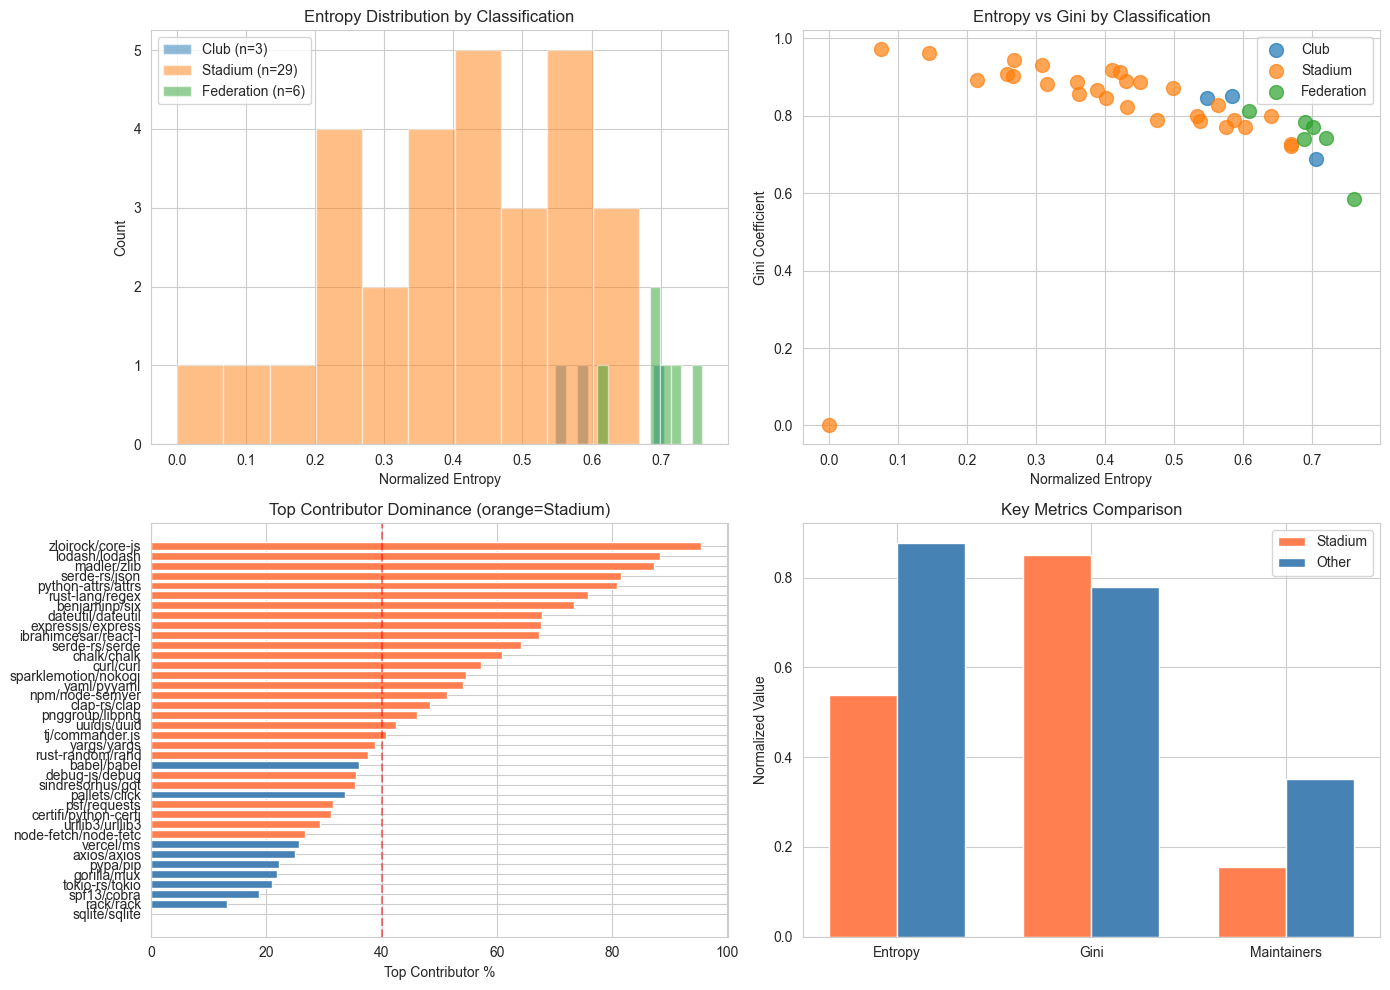


📊 Figure saved to data/processed/statistical_analysis.png


In [24]:
if len(df) >= 2:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Entropy distribution by classification
    ax1 = axes[0, 0]
    for cls in df['classification'].unique():
        data = df[df['classification'] == cls]['normalized_entropy']
        ax1.hist(data, alpha=0.5, label=f"{cls} (n={len(data)})", bins=10)
    ax1.set_xlabel('Normalized Entropy')
    ax1.set_ylabel('Count')
    ax1.set_title('Entropy Distribution by Classification')
    ax1.legend()
    
    # 2. Entropy vs Gini scatter
    ax2 = axes[0, 1]
    for cls in df['classification'].unique():
        subset = df[df['classification'] == cls]
        ax2.scatter(subset['normalized_entropy'], subset['gini'], 
                   label=cls, s=100, alpha=0.7)
    ax2.set_xlabel('Normalized Entropy')
    ax2.set_ylabel('Gini Coefficient')
    ax2.set_title('Entropy vs Gini by Classification')
    ax2.legend()
    
    # 3. Top contributor dominance
    ax3 = axes[1, 0]
    df_sorted = df.sort_values('top_contributor_pct', ascending=True)
    colors = ['coral' if c == 'Stadium' else 'steelblue' for c in df_sorted['classification']]
    ax3.barh(range(len(df_sorted)), df_sorted['top_contributor_pct'], color=colors)
    ax3.set_yticks(range(len(df_sorted)))
    ax3.set_yticklabels([r[:20] for r in df_sorted['repository']])
    ax3.set_xlabel('Top Contributor %')
    ax3.set_title('Top Contributor Dominance (orange=Stadium)')
    ax3.axvline(x=40, color='red', linestyle='--', alpha=0.5, label='40% threshold')
    
    # 4. Summary metrics comparison
    ax4 = axes[1, 1]
    metrics = ['normalized_entropy', 'gini', 'active_maintainers']
    x = np.arange(len(metrics))
    width = 0.35
    
    stadium_means = df[df['classification'] == 'Stadium'][metrics].mean()
    other_means = df[df['classification'] != 'Stadium'][metrics].mean()
    
    # Normalize for comparison
    max_vals = df[metrics].max()
    stadium_norm = stadium_means / max_vals
    other_norm = other_means / max_vals
    
    ax4.bar(x - width/2, stadium_norm, width, label='Stadium', color='coral')
    ax4.bar(x + width/2, other_norm, width, label='Other', color='steelblue')
    ax4.set_xticks(x)
    ax4.set_xticklabels(['Entropy', 'Gini', 'Maintainers'])
    ax4.set_ylabel('Normalized Value')
    ax4.set_title('Key Metrics Comparison')
    ax4.legend()
    
    plt.tight_layout()
    plt.savefig('../data/processed/statistical_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\n📊 Figure saved to data/processed/statistical_analysis.png")
else:
    print("⚠️  Need more data for visualizations")

## 6. Summary Report

In [25]:
print("\n" + "="*70)
print("STATISTICAL ANALYSIS SUMMARY REPORT")
print("="*70)

print(f"\nDataset:")
print(f"  Total projects: {len(df)}")
for cls in df['classification'].value_counts().items():
    print(f"  {cls[0]}: {cls[1]}")

print(f"\nKey Findings:")
print(f"  Stadium normalized entropy: {df[df['classification']=='Stadium']['normalized_entropy'].mean():.3f} (mean)")
print(f"  Non-Stadium normalized entropy: {df[df['classification']!='Stadium']['normalized_entropy'].mean():.3f} (mean)")
print(f"  Stadium Gini coefficient: {df[df['classification']=='Stadium']['gini'].mean():.3f} (mean)")
print(f"  Stadium top contributor %: {df[df['classification']=='Stadium']['top_contributor_pct'].mean():.1f}% (mean)")

print(f"\nHypothesis Results:")
print(f"  H1 (Lower entropy): {'Needs more data' if len(stadium) < 2 else 'See above'}")
print(f"  H2 (Higher Gini): {'Needs more data' if len(stadium) < 2 else 'See above'}")
print(f"  H3 (Correlation): {'Needs more data' if len(valid_data) < 3 else 'See above'}")
print(f"  H4 (Faster merge): {'Needs more data' if len(stadium_merge) < 2 else 'See above'}")
print(f"  H5 (Fewer gov files): {'Needs more data' if len(stadium_gov) < 2 else 'See above'}")
print(f"  H6 (>80% accuracy): {'Needs more data' if len(df) < 10 else 'See above'}")

print(f"\nRecommendations:")
if len(df) < 30:
    print(f"  ⚠️  Collect more Stadium projects (target: 28-30)")
    print(f"     Current: {len(df[df['classification']=='Stadium'])} Stadium projects")
if len(df[df['classification'] != 'Stadium']) < 15:
    print(f"  ⚠️  Need Federation/Club control projects for comparison")

print("\n" + "="*70)


STATISTICAL ANALYSIS SUMMARY REPORT

Dataset:
  Total projects: 38
  Stadium: 29
  Federation: 6
  Club: 3

Key Findings:
  Stadium normalized entropy: 0.409 (mean)
  Non-Stadium normalized entropy: 0.667 (mean)
  Stadium Gini coefficient: 0.825 (mean)
  Stadium top contributor %: 54.2% (mean)

Hypothesis Results:
  H1 (Lower entropy): See above
  H2 (Higher Gini): See above
  H3 (Correlation): See above
  H4 (Faster merge): See above
  H5 (Fewer gov files): See above
  H6 (>80% accuracy): See above

Recommendations:
  ⚠️  Need Federation/Club control projects for comparison



In [26]:
# Export results
output_dir = Path("../data/processed")
output_dir.mkdir(parents=True, exist_ok=True)

# Save analysis DataFrame
df.to_csv(output_dir / "statistical_analysis_results.csv", index=False)
print(f"\n✅ Results saved to {output_dir / 'statistical_analysis_results.csv'}")


✅ Results saved to ../data/processed/statistical_analysis_results.csv
